<h3 class="alert-heading">Комментарий от ревьюера</h3>
<p>Павел, привет!</p>
<p>Меня зовут Алексей Секоцкий. Поздравляю с подготовкой очередного проекта. Предлагаю обращаться друг к другу на «ты» если нет возражений. Ниже стандартный блок с условными обозначениями и напоминанием не удалять мои комментарии:</p>
<div class="alert alert-success" role="alert">
всё отлично
</div>
<div class="alert alert-warning" role="alert">
рекомендации на будущее (не требующие доработки проекта)
</div>
<div class="alert alert-danger" role="alert">
критичные моменты требующие внимания (доработки)
</div>
<div class="alert alert-info">
итоговый комментарий
</div>

<hr>
<p>Пожалуйста, не изменяй и не удаляй мои комментарии – они потребуются для повторной проверки (при необходимости). Задавай вопросы, реагируй на мои комментарии, описывай сделанные изменения, помечая их любым удобным наглядным способом</b>.
</p>

# Оценка рыночной стоимости автомобиля на основе исторических данных

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

______

###### Данное исследование разделено на несколько частей.

* [1. Подготовка данных.](#section1)
* [2. Обучение моделей.](#section2)
* [3. Анализ моделей](#section3)
* [4. Выводы](#section4)



<a id='section1'> </a>

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


**Целевой признак**
* Price — цена (евро)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных выявлены следующие проблемы:
1. В столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired имеются пропуски. Необходимо их заполнить или удалить часть строк.
2. В данных есть строки для которых в столбцах Price, Power или RegistrationMonth указаны нулевые значения, что является аномалией.
3. В столбце с годом регистрации автомобиля встречаются аномалии с очень низкими (min 1000) и очень высокими значениями (9999).
4. Необходимо произвести замену типов данных (в часности столбцы с датами DateCrawled, DateCreated, LastSeen необходимо привести к численным значениям).
5. В столбце NumberOfPictures все значения нулевые. Данный столбец можно удалить.


<div class="alert alert-warning">
<h4> Комментарий от ревьюера</h4>

Хороший анализ. Отмечены пропуски и другие особенности данных.<br>
    
Что можно было бы улучшить: помимо NumberOfPictures у нас есть еще как минимум 3 (а то и 5) не очень полезных нам признаков.
</div>

In [5]:
# убедимся что в столбце NumberOfPictures только нули
df['NumberOfPictures'].unique()

array([0])

In [6]:
# удалим неинформативный столбец
df = df.drop('NumberOfPictures', axis='columns')

Посморим на распределение целевого признака в датасете.

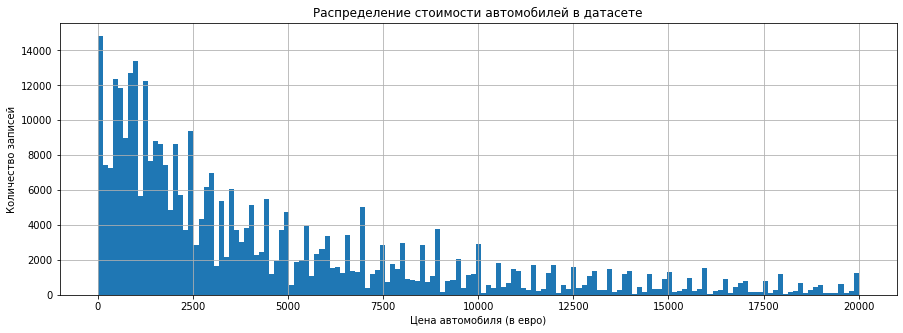

In [7]:
(df['Price'].hist(bins=151, figsize=(15,5))
     .set(xlabel='Цена автомобиля (в евро)', 
      ylabel='Количество записей',  
      title='Распределение стоимости автомобилей в датасете'));

Из линейчатости гистограммы можно сделать вывод, что люди предпочитают устанавливать "куглые" цены на автомобили. Так же на гистограмме имеется ярковыраженный пик в области нулевых цен. Оценим долю строк для которых указана цена автомобиля менее 100 евро

In [8]:
len(df[df['Price']<=100]) / len(df)

0.04048040319553911

Удалим эти строки так как это явная анамалия и в рамках задачи предсказания цены на реальные автомобили данные строки не представляют интереса. Построим гистограмму повторно.

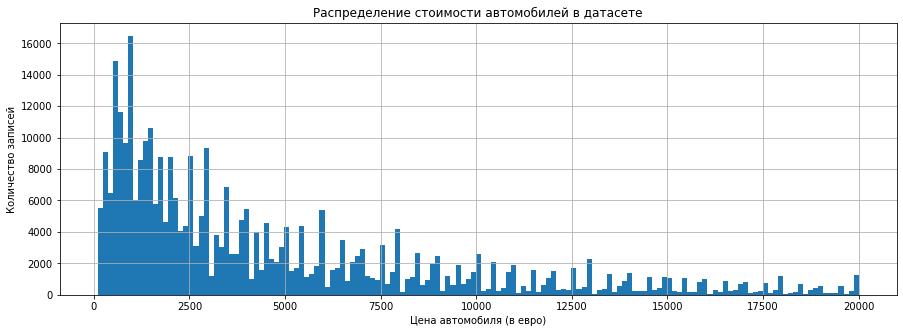

In [9]:
df = df.drop(df.index[df['Price']<=100], axis='index')

(df['Price'].hist(bins=151, figsize=(15,5))
     .set(xlabel='Цена автомобиля (в евро)', 
      ylabel='Количество записей',  
      title='Распределение стоимости автомобилей в датасете'));

Так же дополнительно создадим в датафейме колонку с округленными до 100 евро ценами на автомобили. Попробуем обучить одну из моделей на этом целевом признаке и сравним точность предсказания с моделью обученной на исходном таргете.

In [10]:
df['PriceRounded'] = (np.round(df['Price'] / 100) * 100).astype('int32')

Рассмотрим колонку с мощностью двигателя. По состоянию на 2019 г. самым мощным серийным автомобилем был электрический гиперкар Owl компании Aspark с силовой установкой порядка 2000 л.с. До 60 миль в час (97 километров в час) он разгоняется за 1,69 секунды. 

Удалим из данных все строки с мощностью двигателя более 2500 л.с, а так же с нулевой мощностью и построим гистограмму

In [11]:
df = df.drop((df.index[df['Power']>=2500]) | (df.index[df['Power']==0]), axis='index')

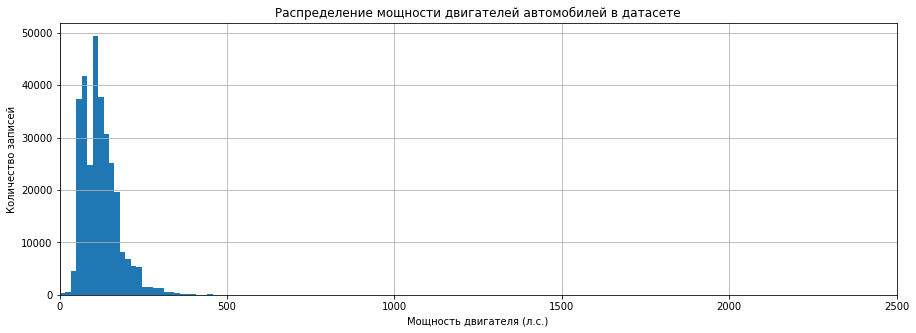

In [12]:
(df['Power'].hist(bins=151, figsize=(15,5))
.set(xlim=(0, 2500),
    xlabel='Мощность двигателя (л.с.)', 
    ylabel='Количество записей',  
    title='Распределение мощности двигателей автомобилей в датасете'));

Рассмотим распределение автомобилей по году регистрации. Ограничим свое рассмотрение только послевоенными годами (с 1945 по наст. вр.)

<div class="alert alert-warning">
<h4> Комментарий от ревьюера</h4>

Нет аргументации почему 1945. Почему ни 1930?
</div>

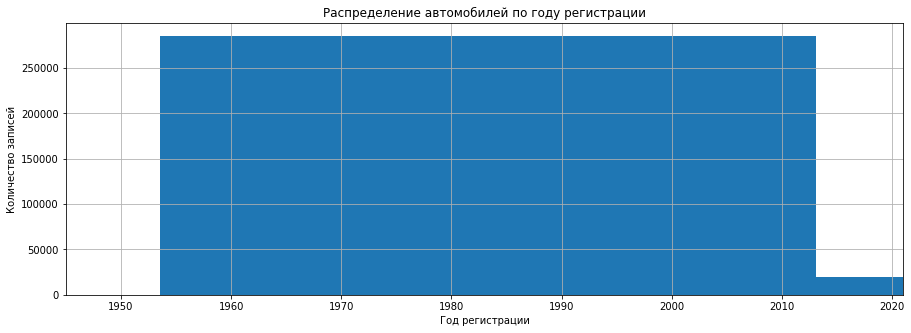

In [13]:
(df['RegistrationYear'].hist(bins=151, figsize=(15,5))
 .set(xlim=(1945, 2021),
    xlabel='Год регистрации', 
    ylabel='Количество записей',  
    title='Распределение автомобилей по году регистрации'));

Поскольку в данных встречаются аномалии с очень низкими значениями (min 1000) и очень высокими значениями (9999), то гистограмма оказалась искаженной. Удалим строки не относящиеся к рассматриваемому периоду и построим гистограмму повторно.

In [14]:
df = df.drop(df.index[(df['RegistrationYear']<=1945) | (df['RegistrationYear']>=2021)], axis='index')

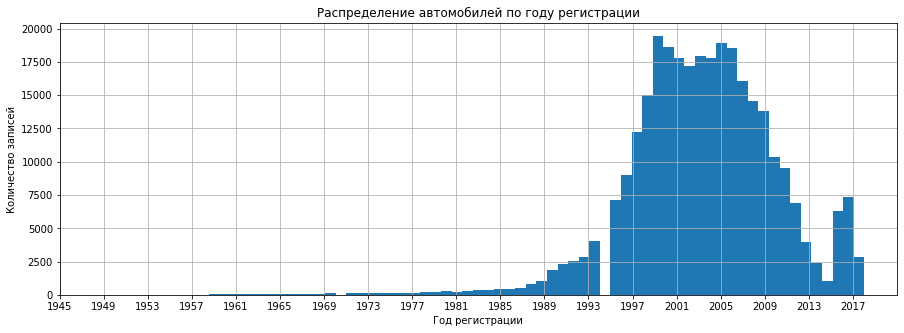

In [15]:
(df['RegistrationYear'].hist(bins=75, figsize=(15,5))
 .set(xlim=(1945, 2021),
    xticks=[x for x in range(1945,2021,4)],
    xlabel='Год регистрации', 
    ylabel='Количество записей',  
    title='Распределение автомобилей по году регистрации'));

По гистограмме видно, что значительное снижение регистрации автомобилей произошло после кризиса 2008-2009 годов, а восстановление рынка началось только в 2015 году.

Посмотрим на уникальные значения которые встречаются в столбце RegistrationMonth

In [16]:
df['RegistrationMonth'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Столбец содержит 13 уникальных значений. Удалим строки для которых указан нулевой месяц регистрации.

In [17]:
df = df.drop(df.index[df['RegistrationMonth']==0], axis='index')
df['RegistrationMonth'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

<div class="alert alert-warning">
<h4> Комментарий от ревьюера</h4>

Что показывает данный признак? ;)
</div>

В столбцах NotRepaired, FuelType, VehicleType, Gearbox, Model незаполненные значения заполним значением 'unknown'

In [18]:
df['NotRepaired'].unique()

array(['yes', nan, 'no'], dtype=object)

In [19]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')
df['NotRepaired'].unique()

array(['yes', 'unknown', 'no'], dtype=object)

In [20]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [21]:
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'].unique()

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [22]:
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [23]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

In [24]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [25]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [26]:
df['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'other', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'astra', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'escort', 'forester', 'xc_reihe', 'scenic', 'a1',
       'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk', '7er',
       'combo', '80', '147', 'z_reihe', 'sportage', 'sorento', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'insignia', 'ka', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'mondeo', 'cordoba', 'colt',
       'corsa', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'panda', 'up',
       'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia',
       'zafira', 'mii', 'rx_reihe', '6er', 'fox', 'matiz', 'beetle',
       'rio', 'touareg', 'logan', 'caddy', 'spider', 'cuore', 's_max',
       'modus', '

In [27]:
df['Model'] = df['Model'].fillna('unknown')

Убедимся что данные больше не содержат строк с незаполненными значениями.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285659 entries, 1 to 354368
Data columns (total 16 columns):
DateCrawled          285659 non-null object
Price                285659 non-null int64
VehicleType          285659 non-null object
RegistrationYear     285659 non-null int64
Gearbox              285659 non-null object
Power                285659 non-null int64
Model                285659 non-null object
Kilometer            285659 non-null int64
RegistrationMonth    285659 non-null int64
FuelType             285659 non-null object
Brand                285659 non-null object
NotRepaired          285659 non-null object
DateCreated          285659 non-null object
PostalCode           285659 non-null int64
LastSeen             285659 non-null object
PriceRounded         285659 non-null int32
dtypes: int32(1), int64(6), object(9)
memory usage: 36.0+ MB


Преобразуем данные с датами к численным значениям.

In [29]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S').astype(int) / 10**9
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S').astype(int) / 10**9
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S').astype(int) / 10**9

<div class="alert alert-warning">
<h4> Комментарий от ревьюера</h4>

Какую ценность несут для нас эти признаки? Как они могут повлиять на цену?
</div>

Выведем текущие типы данных в датафрейме в виде словаря.

In [30]:
df.dtypes.apply(lambda x: x.name).to_dict()

{'DateCrawled': 'float64',
 'Price': 'int64',
 'VehicleType': 'object',
 'RegistrationYear': 'int64',
 'Gearbox': 'object',
 'Power': 'int64',
 'Model': 'object',
 'Kilometer': 'int64',
 'RegistrationMonth': 'int64',
 'FuelType': 'object',
 'Brand': 'object',
 'NotRepaired': 'object',
 'DateCreated': 'float64',
 'PostalCode': 'int64',
 'LastSeen': 'float64',
 'PriceRounded': 'int32'}

In [31]:
# заменим типы в таблице по словарю df_type_dict
df_type_dict = {'DateCrawled': 'float64',
 'Price': 'int32',
 'VehicleType': 'category',
 'RegistrationYear': 'uint16',
 'Gearbox': 'category',
 'Power': 'uint16',
 'Model': 'category',
 'Kilometer': 'int32',
 'RegistrationMonth': 'uint8',
 'FuelType': 'category',
 'Brand': 'category',
 'NotRepaired': 'category',
 'DateCreated': 'float64',
 'PostalCode': 'int32',
 'LastSeen': 'float64',
 'PriceRounded': 'int32'}

df = df.astype(df_type_dict)

# убедимся что замена прошла так как задумано
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285659 entries, 1 to 354368
Data columns (total 16 columns):
DateCrawled          285659 non-null float64
Price                285659 non-null int32
VehicleType          285659 non-null category
RegistrationYear     285659 non-null uint16
Gearbox              285659 non-null category
Power                285659 non-null uint16
Model                285659 non-null category
Kilometer            285659 non-null int32
RegistrationMonth    285659 non-null uint8
FuelType             285659 non-null category
Brand                285659 non-null category
NotRepaired          285659 non-null category
DateCreated          285659 non-null float64
PostalCode           285659 non-null int32
LastSeen             285659 non-null float64
PriceRounded         285659 non-null int32
dtypes: category(6), float64(3), int32(4), uint16(2), uint8(1)
memory usage: 16.4 MB


<div class="alert alert-success">
<h4> Комментарий от ревьюера</h4>

Инетересный подход использовать изменение типа данных вместо кодирования.
</div>

Данные подготовлены, теперь можно переходить к обучению моделей

<a id='section2'> </a>

# 2. Обучение моделей

Создадим списки с названиями целевой переменной и фич, затем разделим выборку на тестовую, тренировачную и валидационную

In [32]:
y_col = ['Price']
x_col = df.columns.drop(y_col + ['PriceRounded'])
x_col

Index(['DateCrawled', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power',
       'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [33]:
train_full, test = train_test_split(df, test_size=0.2, random_state=42)

In [34]:
len(train_full)

228527

In [35]:
len(test)

57132

In [36]:
# проверим соответствие длин датафреймов
len(train_full) + len(test) == len(df)

True

In [37]:
train, val = train_test_split(train_full, test_size=0.2, random_state=42)

In [38]:
len(train) + len(val) == len(train_full)

True

### LightGBM

In [39]:
%%time

lgbm_model = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, random_state=42)

lgbm_model.fit(train[x_col], train[y_col], 
               eval_set=(val[x_col], val[y_col]), 
               verbose=50)

[50]	valid_0's rmse: 1655.39
[100]	valid_0's rmse: 1586.31
[150]	valid_0's rmse: 1563.03
[200]	valid_0's rmse: 1550.76
[250]	valid_0's rmse: 1540.98
[300]	valid_0's rmse: 1534.52
[350]	valid_0's rmse: 1526.45
[400]	valid_0's rmse: 1521.99
[450]	valid_0's rmse: 1518.32
[500]	valid_0's rmse: 1515.96
[550]	valid_0's rmse: 1513.63
[600]	valid_0's rmse: 1510.76
[650]	valid_0's rmse: 1508.78
[700]	valid_0's rmse: 1506.11
[750]	valid_0's rmse: 1505.58
[800]	valid_0's rmse: 1504.8
[850]	valid_0's rmse: 1502.77
[900]	valid_0's rmse: 1500.99
[950]	valid_0's rmse: 1499.49
[1000]	valid_0's rmse: 1497.96
CPU times: user 32min 1s, sys: 11.6 s, total: 32min 13s
Wall time: 32min 34s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [40]:
%%time
lgbm_val_predict = lgbm_model.predict(val[x_col])

CPU times: user 5.71 s, sys: 23.8 ms, total: 5.73 s
Wall time: 5.71 s


In [41]:
lgbm_val_score = np.sqrt(mean_squared_error(val[y_col], lgbm_val_predict))
print('СКО на валидационной выборке:', lgbm_val_score)

СКО на валидационной выборке: 1497.9557455373886


In [42]:
%%time
lgbm_test_predict = lgbm_model.predict(test[x_col])

CPU times: user 7.22 s, sys: 10.7 ms, total: 7.23 s
Wall time: 7.41 s


In [43]:
lgbm_test_score = np.sqrt(mean_squared_error(test[y_col], lgbm_test_predict))
print('СКО на тестовой выборке:', lgbm_test_score)

СКО на тестовой выборке: 1504.885642456331


<div class="alert alert-success">
<h4> Комментарий от ревьюера</h4>

Отличный результат для наших данных.    
</div>

Попробуем обучить моделель на этом целевом признаке с округлением до 100 евро и сравним точность предсказания с моделью обученной на исходном таргете.

In [44]:
%%time

lgbm_model_rounded = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, random_state=42)

lgbm_model_rounded.fit(train[x_col], train['PriceRounded'].values, 
                       eval_set=(val[x_col], val['PriceRounded'].values), 
                       verbose=50)

[50]	valid_0's rmse: 1657.11
[100]	valid_0's rmse: 1587.77
[150]	valid_0's rmse: 1563.76
[200]	valid_0's rmse: 1551.54
[250]	valid_0's rmse: 1543.45
[300]	valid_0's rmse: 1537.64
[350]	valid_0's rmse: 1530.88
[400]	valid_0's rmse: 1526.46
[450]	valid_0's rmse: 1521.32
[500]	valid_0's rmse: 1517.43
[550]	valid_0's rmse: 1513.91
[600]	valid_0's rmse: 1511.78
[650]	valid_0's rmse: 1510.2
[700]	valid_0's rmse: 1506.76
[750]	valid_0's rmse: 1503.82
[800]	valid_0's rmse: 1502.5
[850]	valid_0's rmse: 1500.52
[900]	valid_0's rmse: 1499.48
[950]	valid_0's rmse: 1498.18
[1000]	valid_0's rmse: 1496.12
CPU times: user 1min 28s, sys: 422 ms, total: 1min 29s
Wall time: 1min 30s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [45]:
print('СКО на тестовой выборке:', np.sqrt(mean_squared_error(test[y_col], lgbm_model_rounded.predict(test[x_col]))))

СКО на тестовой выборке: 1506.850311686366


Обе модели дают близкое СКО на тестовых данных. Округление таргета не дает существенного прироста качества модели.

### CatBoost

In [46]:
%%time
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
train_pool = Pool(train[x_col], train[y_col], cat_features=cat_features)
val_pool = Pool(val[x_col], val[y_col], cat_features=cat_features)

CPU times: user 235 ms, sys: 16.8 ms, total: 252 ms
Wall time: 287 ms


In [47]:
%%time
cb_model = CatBoostRegressor(loss_function='RMSE', 
                             eval_metric='RMSE', 
                             random_state=42, 
                             verbose=50, 
                             learning_rate=0.52)

cb_model.fit(train_pool, eval_set=[val_pool])

0:	learn: 3227.9856137	test: 3221.8655107	best: 3221.8655107 (0)	total: 818ms	remaining: 13m 37s
50:	learn: 1667.5101108	test: 1672.7509011	best: 1672.7509011 (50)	total: 36.2s	remaining: 11m 12s
100:	learn: 1583.6002533	test: 1617.2184373	best: 1617.2184373 (100)	total: 1m 11s	remaining: 10m 40s
150:	learn: 1534.9473787	test: 1596.0839070	best: 1595.7663846 (148)	total: 1m 47s	remaining: 10m 4s
200:	learn: 1503.2446890	test: 1586.3328158	best: 1586.3328158 (200)	total: 2m 23s	remaining: 9m 32s
250:	learn: 1476.6601170	test: 1580.6589824	best: 1580.6589824 (250)	total: 3m 2s	remaining: 9m 3s
300:	learn: 1456.0966716	test: 1576.1034972	best: 1576.1034972 (300)	total: 3m 39s	remaining: 8m 30s
350:	learn: 1437.7032997	test: 1572.9658601	best: 1572.9625040 (349)	total: 4m 17s	remaining: 7m 56s
400:	learn: 1420.2032092	test: 1569.1782051	best: 1569.1782051 (400)	total: 4m 55s	remaining: 7m 21s
450:	learn: 1404.1060879	test: 1563.9121542	best: 1563.9121542 (450)	total: 5m 31s	remaining: 6m 4

In [48]:
%%time
cb_val_predict = cb_model.predict(val[x_col])

CPU times: user 925 ms, sys: 62.8 ms, total: 987 ms
Wall time: 933 ms


In [49]:
cb_val_score = np.sqrt(mean_squared_error(val[y_col], cb_val_predict))
print('СКО на валидационной выборке:', cb_val_score)

СКО на валидационной выборке: 1552.1433157348863


In [50]:
%%time
cb_test_predict = cb_model.predict(test[x_col])

CPU times: user 1.17 s, sys: 41.6 ms, total: 1.21 s
Wall time: 1.21 s


In [51]:
cb_test_score = np.sqrt(mean_squared_error(test[y_col], cb_test_predict))
print('СКО на тестовой выборке:', cb_test_score)

СКО на тестовой выборке: 1548.6244160335532


<div class="alert alert-success">
<h4> Комментарий от ревьюера</h4>

Здесь тоже отличный результат :)
</div>

### Линейная регрессия

Прежде чем применять линейные алгоритмы необходимо отмасштабировать числовые признаки

In [52]:
num_col = x_col.drop(cat_features)
num_col

Index(['DateCrawled', 'RegistrationYear', 'Power', 'Kilometer',
       'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

In [53]:
scaler = StandardScaler()
scaler.fit(train[num_col])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [54]:
train_scaled = train.copy()
train_scaled[num_col] = scaler.transform(train_scaled[num_col])
val_scaled = val.copy()
val_scaled[num_col] = scaler.transform(val_scaled[num_col])
test_scaled = test.copy()
test_scaled[num_col] = scaler.transform(test_scaled[num_col])

Так же заменим категориальные переменные используя технику OHE

<div class="alert alert-success">
<h4> Комментарий от ревьюера</h4>

Супер, что не забыл под Линейную регрессию закодировать призанаки.
</div>

In [55]:
train_scaled = pd.get_dummies(train_scaled, drop_first=True)
val_scaled = pd.get_dummies(val_scaled, drop_first=True)
test_scaled = pd.get_dummies(test_scaled, drop_first=True)

In [56]:
x_col_lr = train_scaled.columns.drop(y_col + ['PriceRounded'])
x_col_lr

Index(['DateCrawled', 'RegistrationYear', 'Power', 'Kilometer',
       'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen',
       'VehicleType_convertible', 'VehicleType_coupe',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_unknown', 'NotRepaired_yes'],
      dtype='object', length=314)

In [57]:
%%time
lr_model = LinearRegression()
lr_model.fit(train_scaled[x_col_lr], train_scaled[y_col])

CPU times: user 16 s, sys: 4.68 s, total: 20.6 s
Wall time: 20.7 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
%%time
lr_val_predict = lr_model.predict(val_scaled[x_col_lr])

CPU times: user 129 ms, sys: 51.8 ms, total: 181 ms
Wall time: 190 ms


In [59]:
lr_val_score = np.sqrt(mean_squared_error(val_scaled[y_col], lr_val_predict))
print('СКО на валидационной выборке:', lr_val_score)

СКО на валидационной выборке: 2657.503452767828


In [60]:
%%time
lr_test_predict = lr_model.predict(test_scaled[x_col_lr])

CPU times: user 79.7 ms, sys: 56.1 ms, total: 136 ms
Wall time: 114 ms


In [61]:
lr_test_score = np.sqrt(mean_squared_error(test_scaled[y_col], lr_test_predict))
print('СКО на тестовой выборке:', lr_test_score)

СКО на тестовой выборке: 2673.488519081716


### K ближайших соседей

In [62]:
%%time
knn_model = KNeighborsRegressor()
knn_model.fit(train_scaled[x_col_lr], train_scaled[y_col])

CPU times: user 9.72 s, sys: 315 ms, total: 10 s
Wall time: 10.1 s


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [63]:
%%time
knn_val_predict = knn_model.predict(val_scaled[x_col_lr])

CPU times: user 13min 50s, sys: 0 ns, total: 13min 50s
Wall time: 13min 59s


In [64]:
knn_val_score = np.sqrt(mean_squared_error(val_scaled[y_col], knn_val_predict))
print('СКО на валидационной выборке:', knn_val_score)

СКО на валидационной выборке: 2118.345495244401


In [ ]:
%%time
knn_test_predict = knn_model.predict(test_scaled[x_col_lr])

<div class="alert alert-warning">
<h4> Комментарий от ревьюера</h4>

Очень долгое обучение для такого качества модели.
</div>

In [ ]:
knn_test_score = np.sqrt(mean_squared_error(test_scaled[y_col], knn_test_predict))
print('СКО на тестовой выборке:', lr_test_score)

<a id='section3'> </a>

# 3. Анализ моделей

Составим сводную таблицу на осове данных полученых в процессе обучения

In [ ]:
pd.DataFrame({'Модель': ['LightGBM', 'CatBoost', 'Линейная регрессия', 'K ближайших соседей'],
'СКО оценки стоимости на валидационной выборке, евро': [lgbm_val_score, cb_val_score, lr_val_score, knn_val_score],
'СКО оценки стоимости на тестовой выборке, евро': [lgbm_test_score, cb_test_score, lr_test_score, knn_test_score], 
'Время обучения модели': ['1min 5s', '12min 28s', '20.8 s', '11.3 s'],
'Время вычисления предсказаний на валидационной выборке': ['5.99 s', '918 ms', '144 ms', '14min 35s'],
'Время вычисления предсказаний на тестовой выборке': ['7.43 s', '1.27 s', '115 ms', '19min 51s'],
})

Наибольшей точностью оценки стоимости автомобилей по предоставленным данным обладает модель LightGBM (СКО ~1505 евро). Близкой по точности является модель CatBoost (СКО ~1552 евро). При этом CatBoost формирует предсказания примерно в 6 раз быстрее, чем LightGBM (порядка 1 с против 6 с у LightGBM). Недостатком CatBoost является большее время на обучение модели (12 мин против 1 мин у LightGBM).

<div class="alert alert-success">
<h4> Комментарий от ревьюера</h4>

Хорошее решение сводить результаты в одну табличку. Могу порекомендовать в будущем сравнивать полученные результаты с константной моделью (медианой или средним).
</div>

<a id='section4'> </a>

# Выводы

В процессе исследования были выполнены следующие работы:
1. Проведена подготовка данных (устранены аномалии, заполнены пропуски)
2. Обучено несколько моделей прогнозирования цены на автомобили. Рассмотренные модели:
    * LightGBM
    * CatBoost
    * Линейная регрессия
    * K ближайших соседей
3. Проведен анализ эффективности моделей

Наибольшей точностью оценки стоимости автомобилей по предоставленным данным обладает модель LightGBM (СКО 1505 евро). При этом в случае если для пользователей небходимо предсказывать цену в режиме близком к реальному времени, рекумендуется использовать модель CatBoost. Данная модель дает близкое СКО (~1552 евро), но существенный выйгрыш по времени предсказания. В случае если скорость обучения модели важнее скорости предсказания, рекомендуется использовать модель LightGBM.

<div class="alert alert-info">
<h4> Итоговый комментарий от ревьюера</h4>

Классный проект! Видно глубокое понимание темы и умение работать с разными способами кодирования и моделями. Оформление и выводы тоже на высоте. Желаю успехов в дальнейшем обучении! Впереди ещё много интересных тем :)
</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей